Project developed by: [Gabriel Pacheco](https://linkedin.com/in/gabriel-pacheco37)

---

This notebook will be divided in two parts:
1. **Data Wrangling**: Handling missing values, standardize column names.
2. **Data Analysis**: An initial analysis of patterns and correlations.

---

**Import libraries and data**

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd

import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Creating Spark Context and Spark Session
sc = SparkContext(appName='teleco-customer-churn')
spark = SparkSession.builder.getOrCreate()
spark

In [3]:
data_path = '../data/'
data_file = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
customers_table_raw = spark.read.csv(data_path + data_file, header='true', inferSchema='true')

### Data Wrangling

Check points:
1. Checking data types
2. Treating missing values
3. Standardizing column names

---

Results:
1. All data types were correctly inferred. But we have some categorical data that will need treatment before we train our models.
2. There were 11 empty values on the TotalCharges columns from customers that didn't had any charges yet. We filled those values with 0.00.
3. The CustomerID and Gender columns used camelCase white the remaining columns used PascalCase. We've set Pascal as the costume case.
---

In [4]:
customers_table_raw.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

Get the total number of rows:

In [5]:
customers_table_raw.count()

7043

In [9]:
type(customers_table_raw)

pyspark.sql.dataframe.DataFrame

**Checking data types**

In [7]:
customers_table_raw.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'string'),
 ('Churn', 'string')]

**Treating null and empty values**

Since Spark only let's us check null values if we filter column by column, we'll create this little loop and check if it returns any row.

In [33]:
def check_null_values(dataframe):
    dataframe_columns = dataframe.columns
    null_values_by_columns = {}

    for column in dataframe_columns:
        column_null_values = dataframe.filter(f'{column} is NULL')
        if column_null_values.count() > 0:
            null_values_by_columns[column] = column_null_values.count()

    if len(null_values_by_columns) == 0:
        print('Great! There are no null values.')
    else:
        print(null_values_by_columns)

def check_empty_values(dataframe):
    dataframe_columns = dataframe.columns
    null_values_by_columns = {}

    for column in dataframe_columns:
        column_null_values = dataframe.filter(f"{column} = '' OR {column} = ' '")
        if column_null_values.count() > 0:
            null_values_by_columns[column] = column_null_values.count()

    if len(null_values_by_columns) == 0:
        print('Great! There are no empty values.')
    else:
        print('Columns with empty values:\n', null_values_by_columns)

In [34]:
check_null_values(customers_table_raw)
check_empty_values(customers_table_raw)

Great! There are no null values.
Columns with empty values:
 {'TotalCharges': 11}


In [39]:
customers_table_raw.filter("TotalCharges = '' OR TotalCharges = ' '").show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|4472-LVYGI|Female|            0|    Yes|       Yes|     0|          No|No phon

We found some lines with empty TotalCharges. This occured because the customers were still on their first month and didn't had any charges yet, so we'll fill those values with 0.00.

In [40]:
customers_table = customers_table_raw.replace(subset='TotalCharges', to_replace=' ', value='0.00')
customers_table = customers_table.withColumn('TotalCharges', customers_table.TotalCharges.cast('double'))

**Standardizing column names**

A clean code requires standards, and there's a few column names that are a bit off. Let's fix it!

In [41]:
customers_table = customers_table.withColumnRenamed('gender', 'Gender').withColumnRenamed('tenure', 'Tenure').withColumnRenamed('customerId', 'CustomerId')
customers_table.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|CustomerId|Gender|SeniorCitizen|Partner|Dependents|Tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

We're all good with data wrangling for now. 

Let's move on to a exploratory analysis using a few charts. 

---

### Data Analysis

Our analysis allowed us to get a better understanding of tha data we have in hands and an understanding of the customers behavior regarding their churn patterns. Here we'll list some of the conclusions we draw from our analysis, but more can be found on other comments below:

 - The most important observation is that 43% of customers who had month-to-month contracts left the company, against only 11% from customers that had 1 year contracts. This is crucial to determine our business strategies.
 - We've also noticed a correlation between our churn label and whether the customer has opted-in for extra services. Customers with extra services are less likely to leave the company.
 - Clients that use fiber optic have a 42% churn-rate. They also represent around 70% of all the customer who left the company.

This are some insight that might have a deep impact on solving our business problem, and will be explored further in our project.

For this we'll need to convert the spark dataframe to a pandas dataframe, it's easier this way. Since the dataset isn't that big, we can tranfer the whole thing to pandas, instead of just a sample.

In [9]:
pd_customers_table = customers_table.toPandas()

We'll get the help from Sweetviz to create a dashboard with some intresting visuals.

Note: In case you aren't familiar with Sweetviz I really recomend taking a look at it. It's a really helpful tool, that speeds up the whole process of analysis.

                                             |          | [  0%]   00:00 -> (? left)


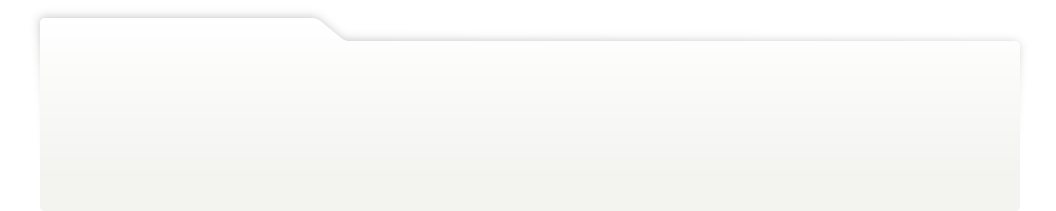
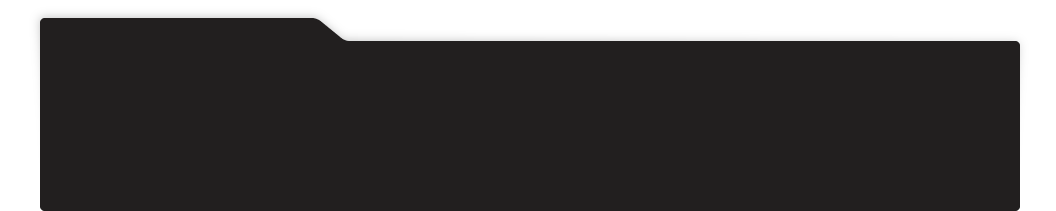
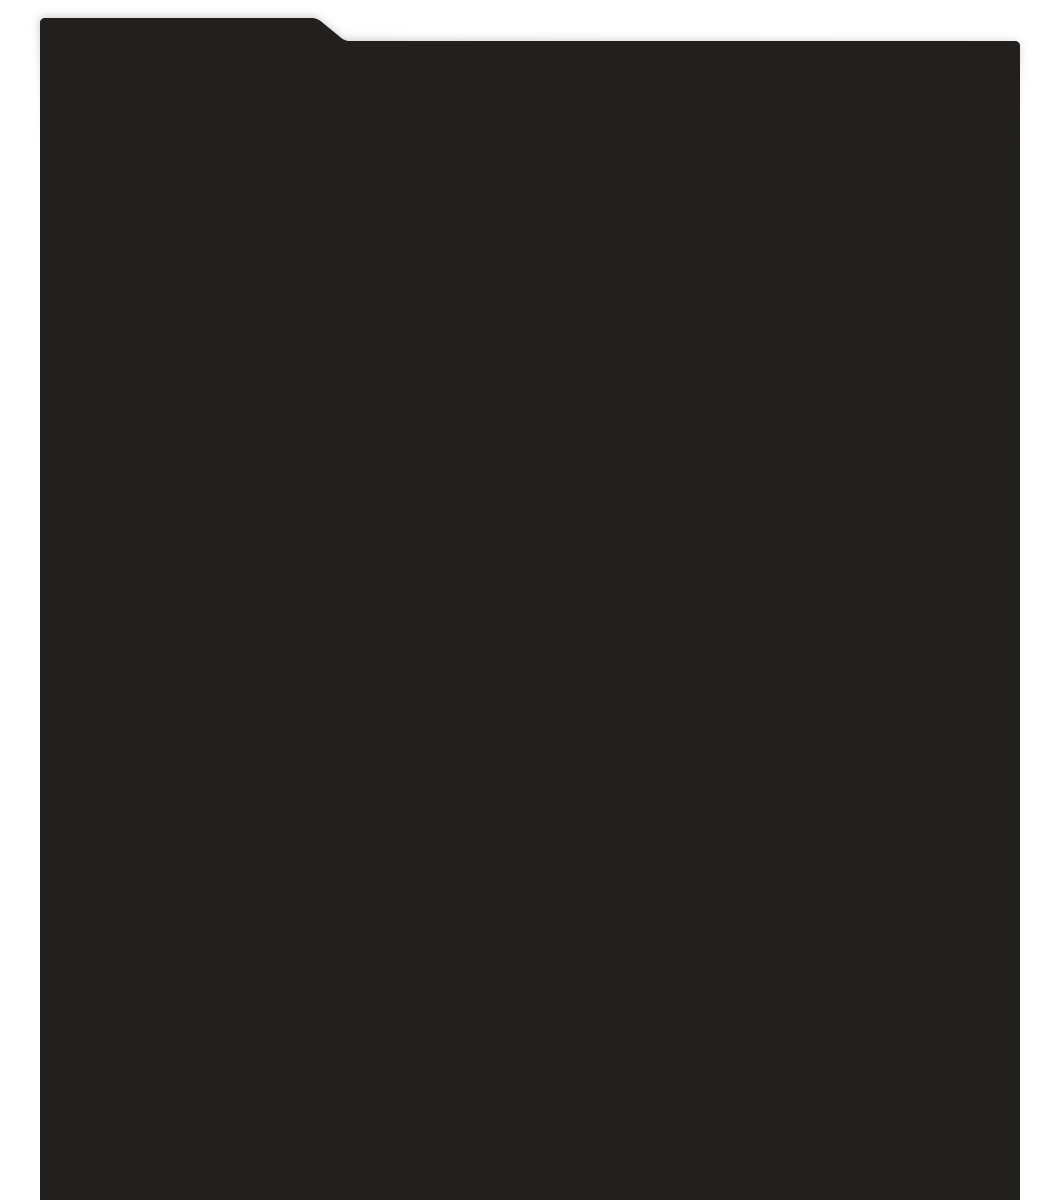
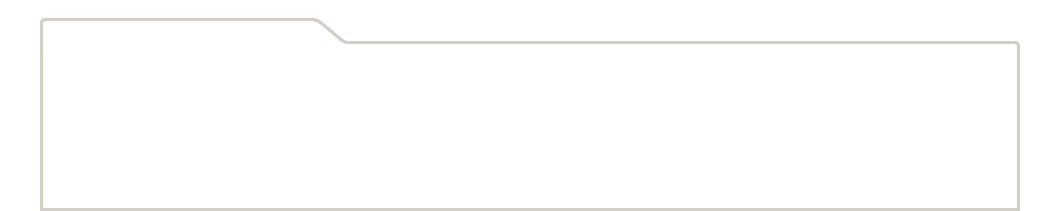
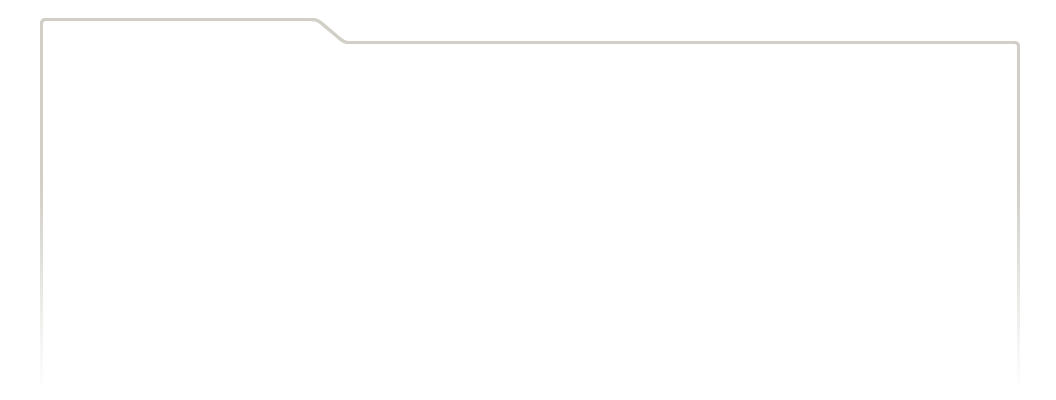
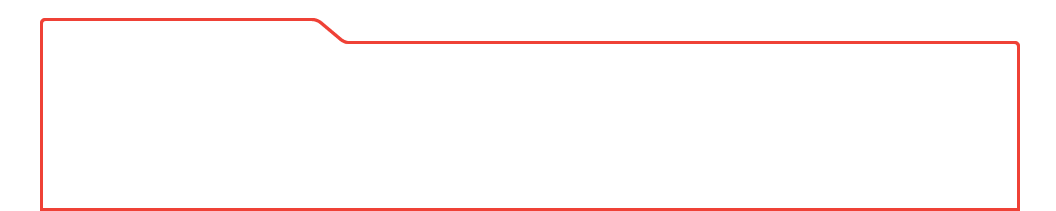
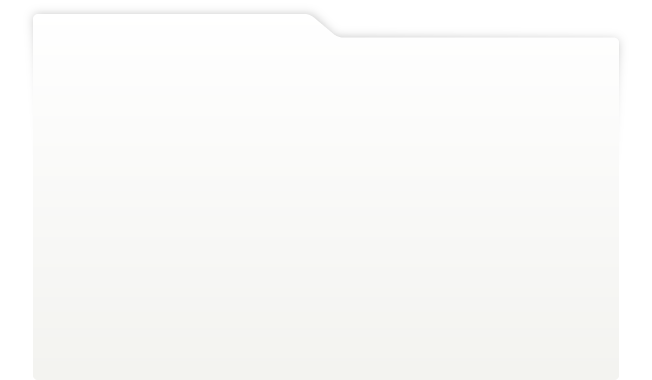
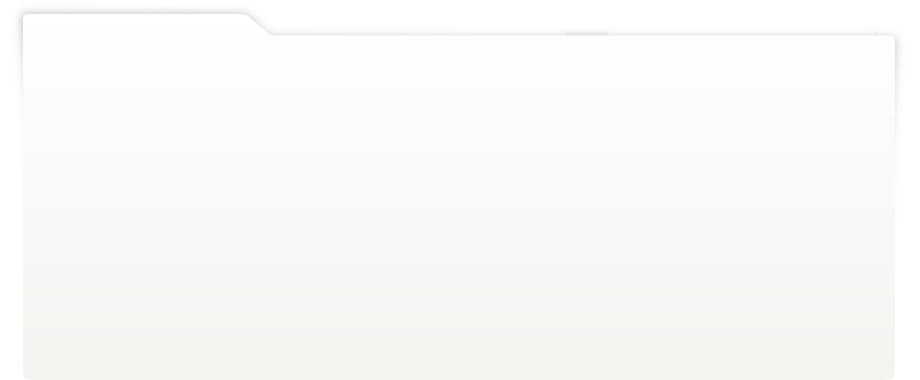
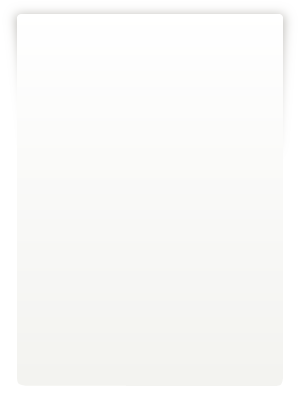
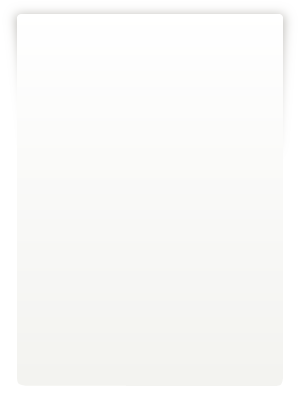
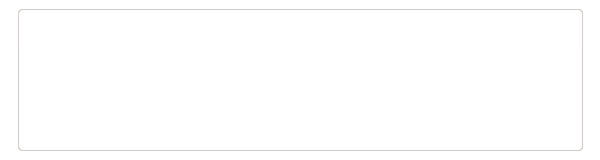
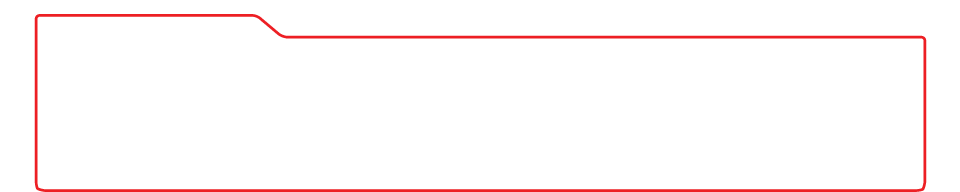
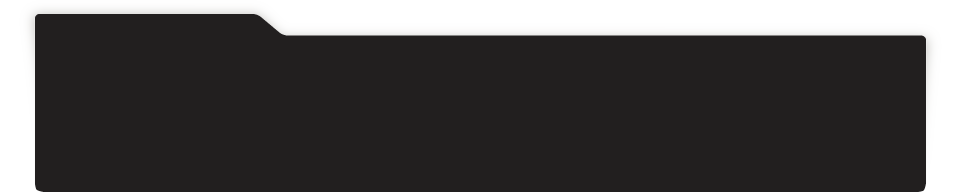
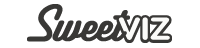
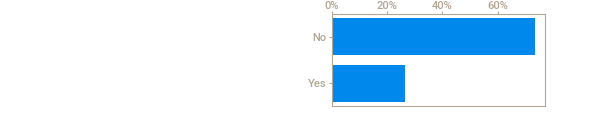
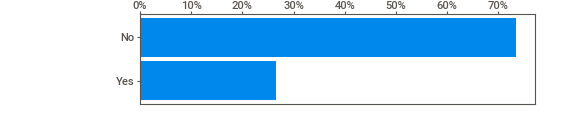
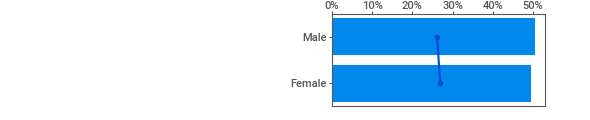
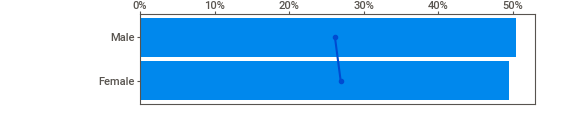
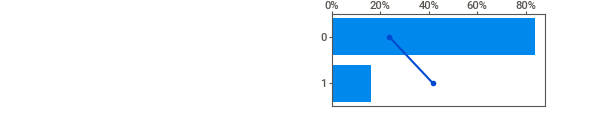
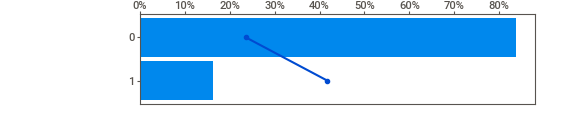
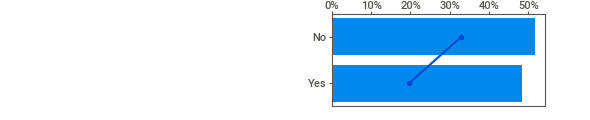
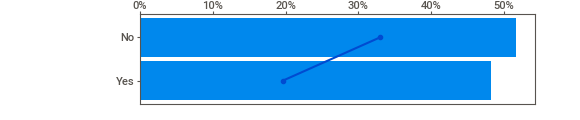
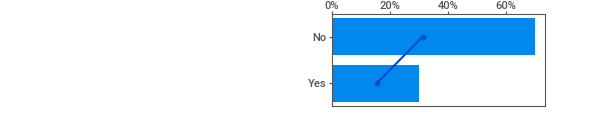
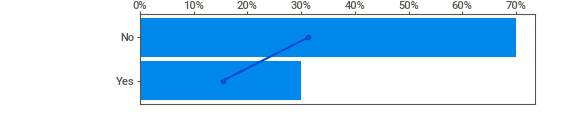
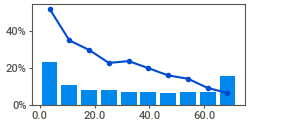
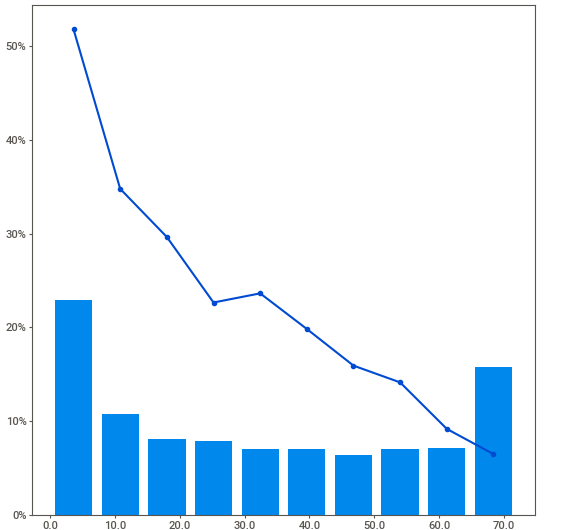
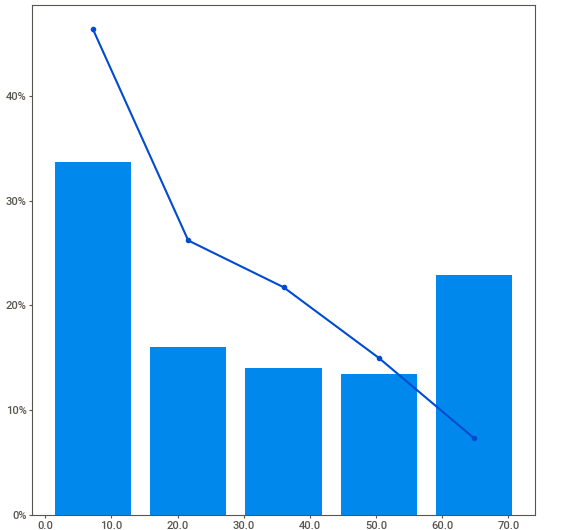
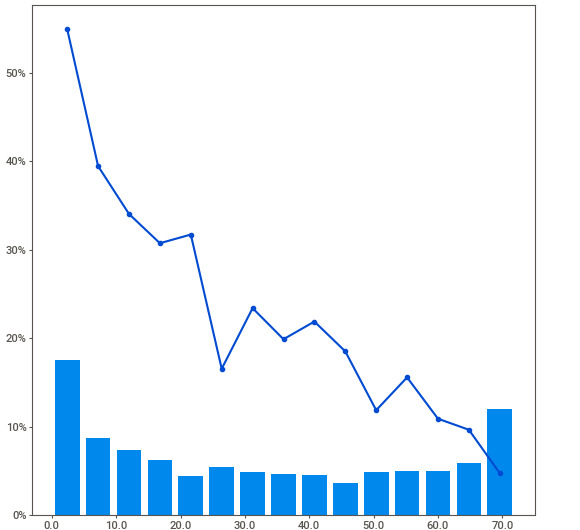
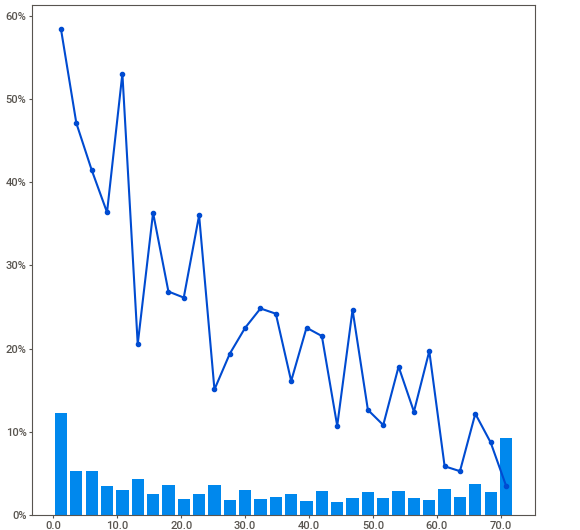
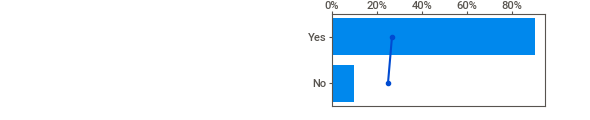
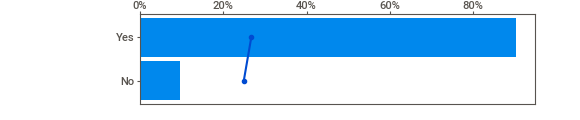
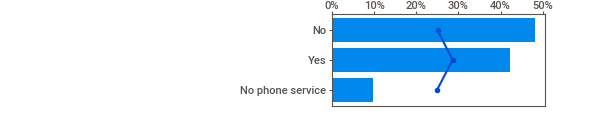
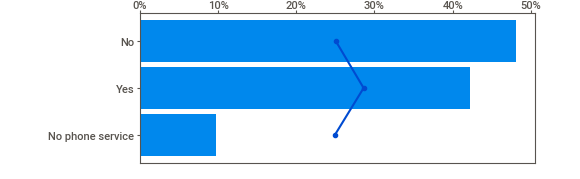
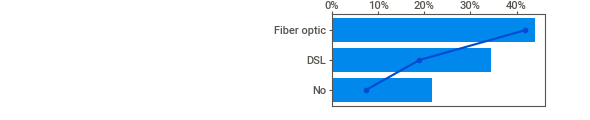
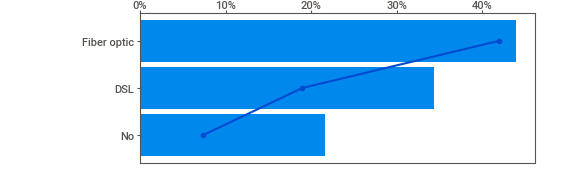
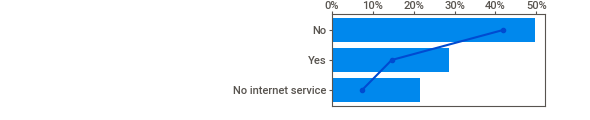
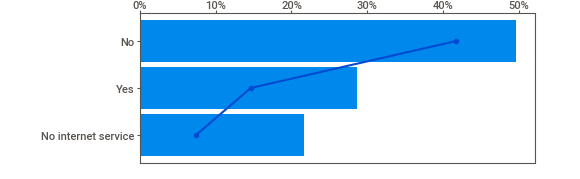
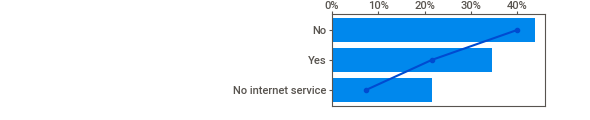
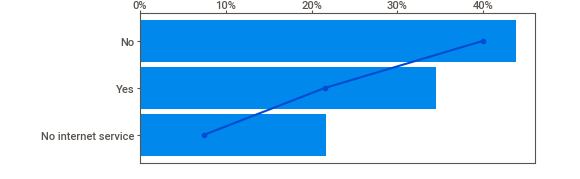
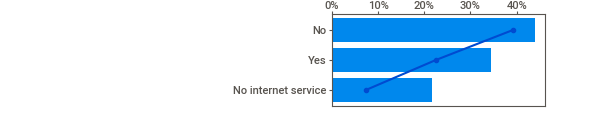
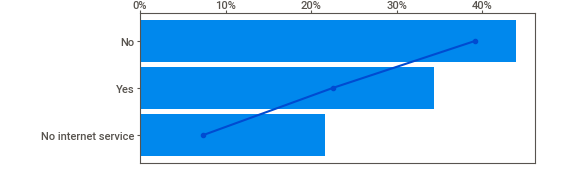
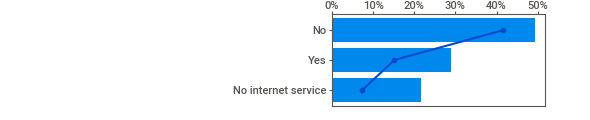
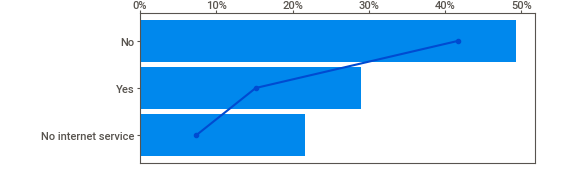
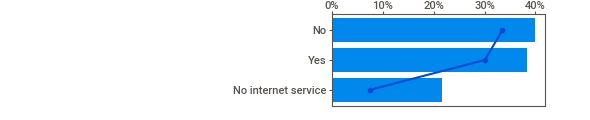
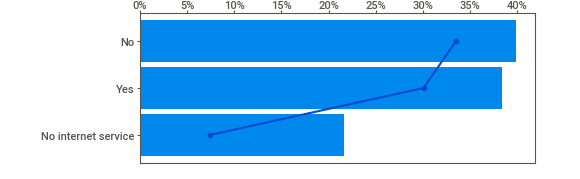
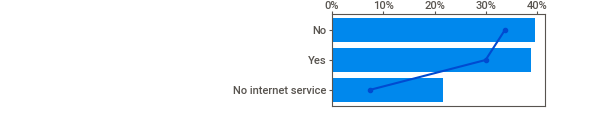
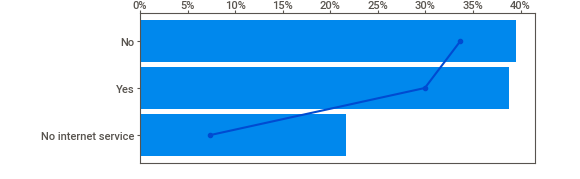
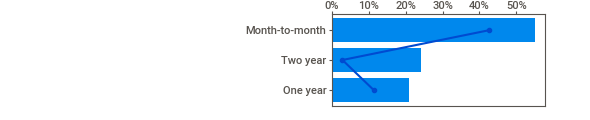
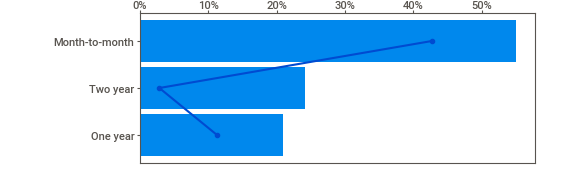
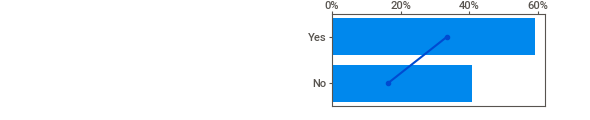
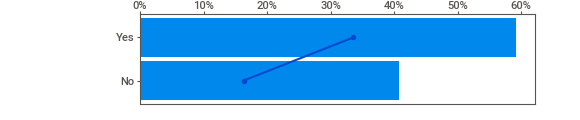
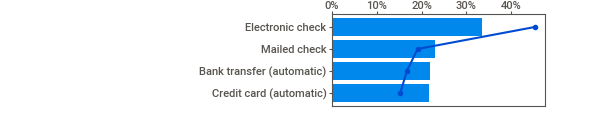
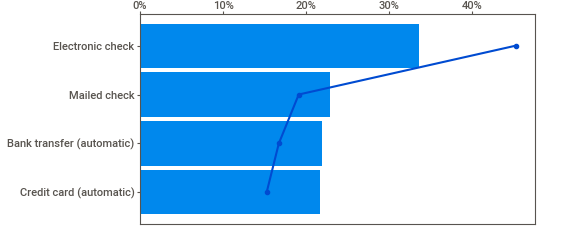
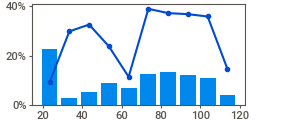
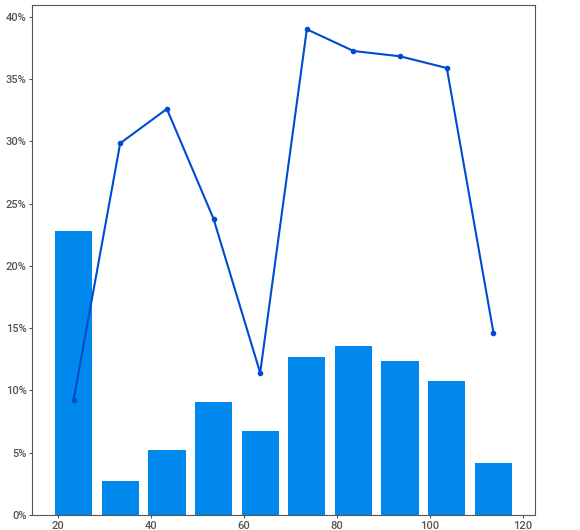
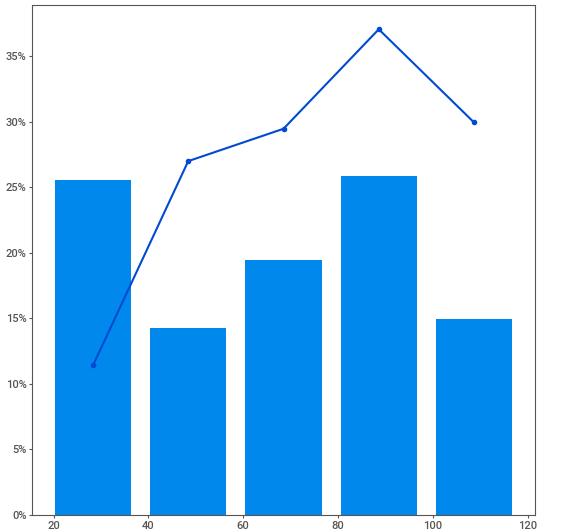
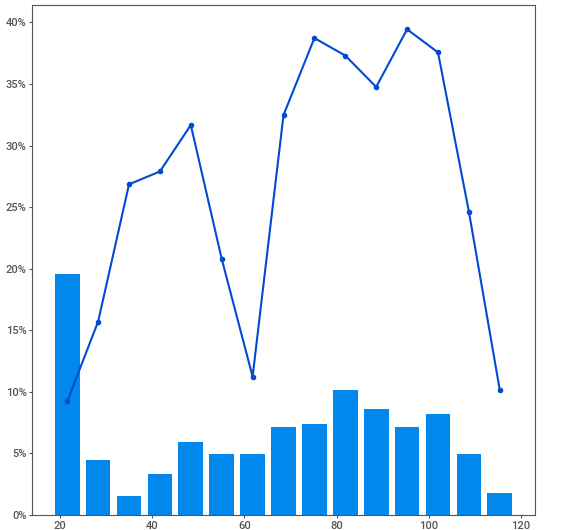
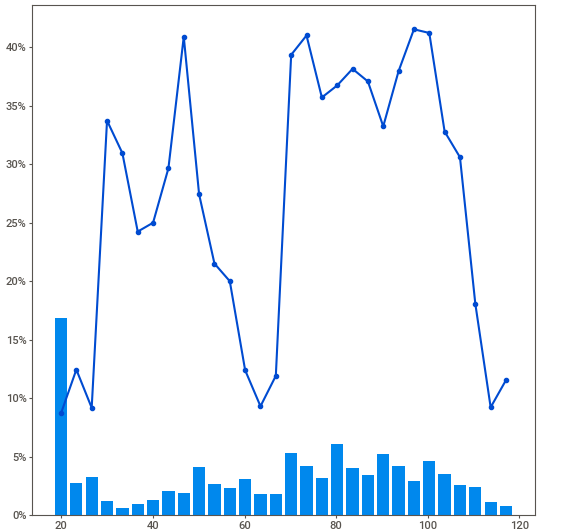
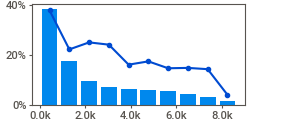
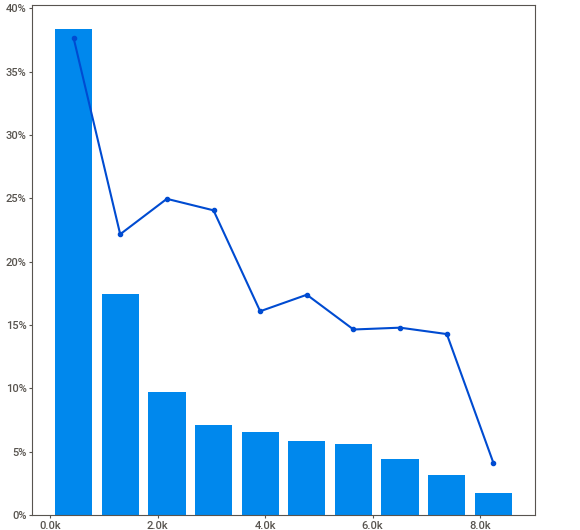
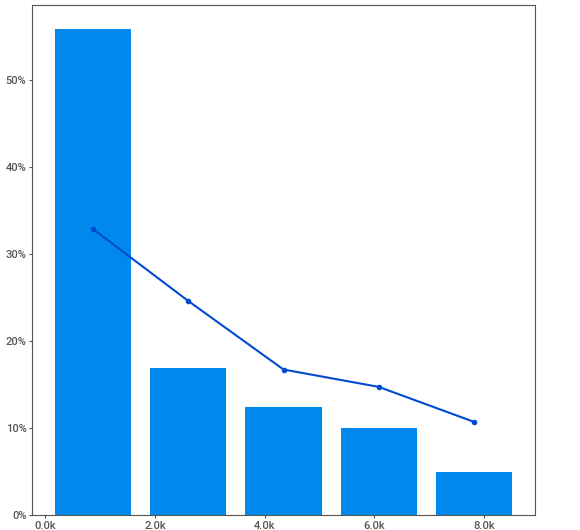
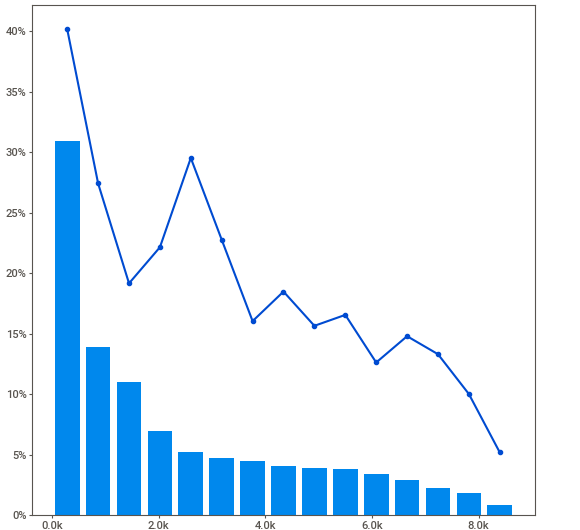
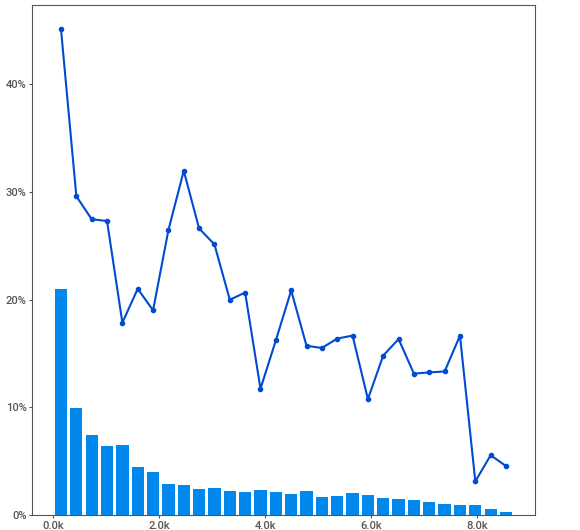
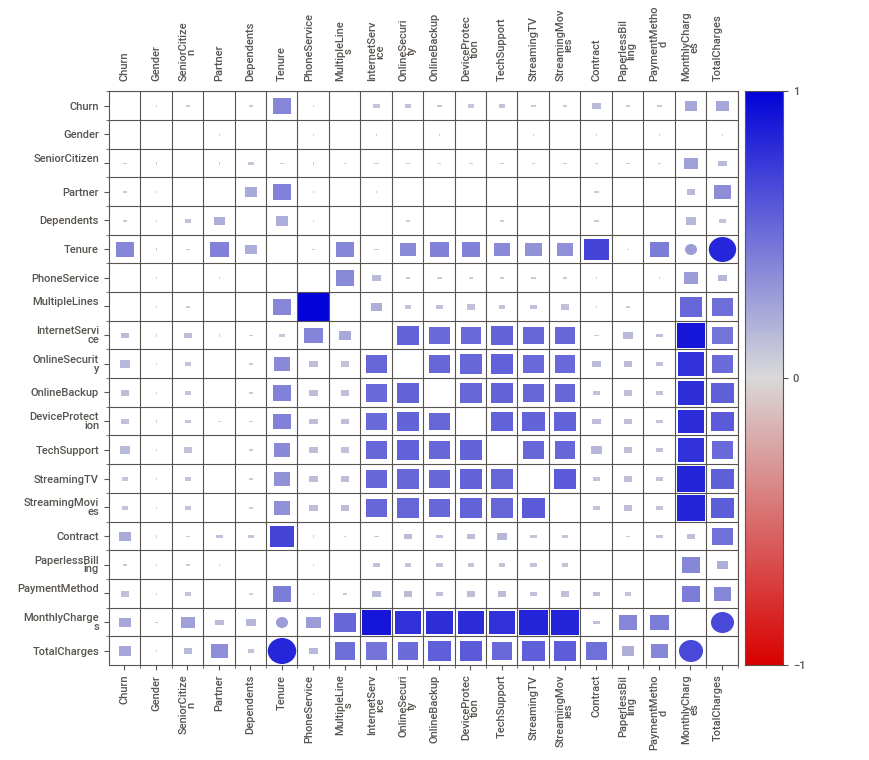
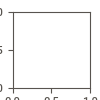

In [10]:
sv_dashboard = sv.analyze(pd_customers_table, target_feat='Churn')
sv_dashboard.show_notebook()

#### Here's some observations that we can extract from Sweetviz

- The **'Churn'** target variable is quite **unbalanced**, with around 5K "No" and 2K "Yes". That's something that we'll have to consider in pre-processing.
- **SeniorCitizen:** Although we have around **80% "Non-Seniors"**, the "Seniors" have a way higher **Churn rate**, with **42%** of **Seniors** leaving the company, versus a **24% "Non-Seniors" Churn rate**. The 'Why?' is something that we can't answer with this data and may need a deeper study.
- **Partner and Dependents:** Customers with **no partner** tend to leave on a **33%** rate, while customers **with partner** do it on a **20%**. A similiar thing happend with **dependents**, where customers with **no dependents** tend to leave on a higher rate.
- **InternetService:** Clients that have a **fiber optic** internet service present a **42% churn rate**, against a **19% churn rate** from customers with **DSL** internet service. This might happend due to poor service, high prices or maybe it's just a specific trait from that particular group of clients. Whatever is the cause, it demands a deeper study. Particulary since ~1300 out of ~1900 customers who churned use fiber optic.
- **Additional Services (OnlineSecurity, Online Backup, DeviceProtection, TechSupport):** There is a pack of additional services that present a similiar behavior, where customer that didn't opt for this services present higher churn rates. This call for an analysis that can understand if those customers are the same group of customers for every service, and what other things they have in common.
- **Contract:** This is a intresting one! **43%** of the customers with a **month-to-month** contract, tend to **churn**, while clients with **one year** or **two year** contracts, have a **churning rate** of **11%** and **3%** respectively. Some strategy need to be created to address those M-T-M customers.
- **Billing** When we talk about billing, there is a clear bias where customers that opted for paperless billing present a twice as high churn rate. *I suppose* this is one of those correlation != causation, and making people use paper billing won't cause them to remain customers and not churning.
- **PaymentMethod:** Here we find another trend where user who manually have to pay their checks, either electronic or mailed, have higher churn rates, than customers who have the payment being done automatically.


I left the numeric variables out purposely, as sweetviz didn't present a clear analysis, and I will be doing that analysis manually.


**Tenure Analysis**

As we can see on the chart below, most clients leave the company on their first month of contract, and then things get more stable.

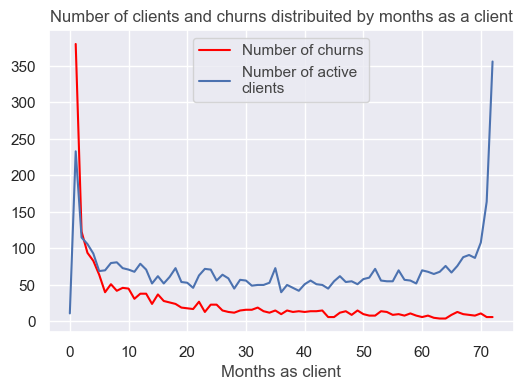

In [11]:
sns.set_theme()
sns.lineplot(x=pd_customers_table[pd_customers_table['Churn']=='Yes']['Tenure'].value_counts().sort_index().index, 
             y=pd_customers_table[pd_customers_table['Churn']=='Yes']['Tenure'].value_counts().sort_index().values,
             color='red')

sns.lineplot(x=pd_customers_table[pd_customers_table['Churn']=='No']['Tenure'].value_counts().sort_index().index, 
             y=pd_customers_table[pd_customers_table['Churn']=='No']['Tenure'].value_counts().sort_index().values)

plt.title('Number of clients and churns distribuited by months as a client', fontdict={'color':'#444444'})
plt.xlabel('Months as client', fontdict={'color':'#444444'})
plt.legend(loc='upper center', labels=['Number of churns', 'Number of active\nclients'], labelcolor='#444444')
plt.show()

**Monthly Charges Analysis**

We can notice a distinct amount of churns happening among the group of clients that get charged between 70 USD to 90 USD monthly. 

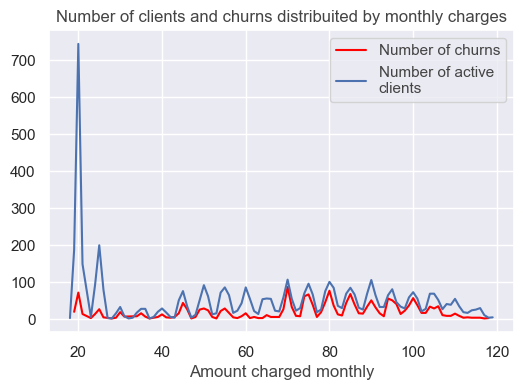

In [12]:
sns.lineplot(x=pd_customers_table[pd_customers_table['Churn']=='Yes']['MonthlyCharges'].round().value_counts().sort_index().index, 
             y=pd_customers_table[pd_customers_table['Churn']=='Yes']['MonthlyCharges'].round().value_counts().sort_index().values,
             color='red')

sns.lineplot(x=pd_customers_table[pd_customers_table['Churn']=='No']['MonthlyCharges'].round().value_counts().sort_index().index, 
             y=pd_customers_table[pd_customers_table['Churn']=='No']['MonthlyCharges'].round().value_counts().sort_index().values)

plt.title('Number of clients and churns distribuited by monthly charges', fontdict={'color':'#444444'})
plt.xlabel('Amount charged monthly', fontdict={'color':'#444444'})
plt.legend(loc='upper right', labels=['Number of churns', 'Number of active\nclients'], labelcolor='#444444')

plt.show()

---

### Conclusion

We are able to create a better understanding of the data at our hands. We understood better some of the variables that have a correlation to the churn variable, and now, we can move onto creating our predictive models.

In [13]:
spark.stop()
sc.stop()